### Load data

In [51]:
import numpy as np
import pandas as pd

# Load data
debt_df = pd.read_csv("Debt_Series.csv")

# Filter series

# Filter series
debt_df = debt_df.rename(columns={'datadate': 'Date'})
debt_df['Date'] = pd.to_datetime(debt_df['Date']) 
debt_df = debt_df.set_index('Date')
debt_df = debt_df.sort_index() #sort by date


In [52]:
# Get correct data range for interpolation
debt_df_period = debt_df.loc["2023-09-30":"2024-12-31"]
print(debt_df_period.head())

            gvkey  fyearq  fqtr indfmt consol popsrc datafmt curcdq datacqtr  \
Date                                                                           
2023-09-30   2055    2023     3   INDL      C      D     STD    USD   2023Q3   
2023-12-31   2055    2023     4   INDL      C      D     STD    USD   2023Q4   
2024-03-31   2055    2024     1   INDL      C      D     STD    USD   2024Q1   
2024-06-30   2055    2024     2   INDL      C      D     STD    USD   2024Q2   
2024-09-30   2055    2024     3   INDL      C      D     STD    USD   2024Q3   

           datafqtr  dlcq   dlttq costat  
Date                                      
2023-09-30   2023Q3   8.0  4767.0      A  
2023-12-31   2023Q4  43.0  5180.0      A  
2024-03-31   2024Q1  12.0  4713.0      A  
2024-06-30   2024Q2  11.0  4713.0      A  
2024-09-30   2024Q3  13.0  4712.0      A  


### Linearly interpolate $L_t$

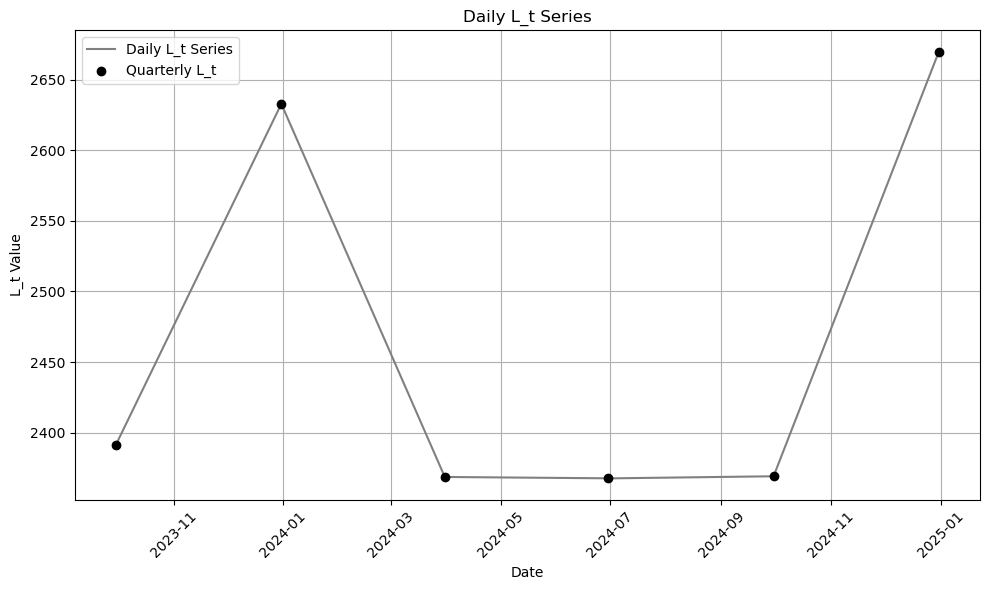

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure Date is the index (already done, but just in case)
debt_df_period.index = pd.to_datetime(debt_df_period.index)

# Create a copy of debt_df_period to avoid SettingWithCopyWarning
debt_df_period_copy = debt_df_period.copy()

# Define L_t using .loc to avoid the SettingWithCopyWarning
debt_df_period_copy.loc[:, "L_t"] = debt_df_period_copy["dlcq"] + 0.5 * debt_df_period_copy["dlttq"]

# Create a daily date range covering the period of the available data
daily_dates = pd.date_range(start=debt_df_period_copy.index.min(), end=debt_df_period_copy.index.max())

# Create a daily DataFrame and join the quarterly data
daily_debt = pd.DataFrame(index=daily_dates)

# Join the quarterly L_t data to the daily DataFrame by reindexing
daily_debt = daily_debt.join(debt_df_period_copy[['L_t']])

# Perform linear interpolation only on the joined data
daily_debt['L_t'] = daily_debt['L_t'].interpolate(method='linear')

# Plotting the L_t series
plt.figure(figsize=(10, 6))

# Plot the interpolated L_t as a line
plt.plot(daily_debt.index, daily_debt["L_t"], label="Daily L_t Series", color='grey')

# Plot the non-interpolated L_t values as scatter points
# The original data points (quarterly) are added as scatter points on top of the line
plt.scatter(debt_df_period_copy.index, debt_df_period_copy["L_t"], color='black', label='Quarterly L_t', zorder=5)

# Add labels and titles
plt.title("Daily L_t Series")
plt.xlabel("Date")
plt.ylabel("L_t Value")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()


### Construct market cap daily series

In [43]:
# Open file
stock_df = pd.read_excel("Crisp_daily_time_series_71298.xlsx")

# Filter series
stock_df = stock_df.rename(columns={'Names Date': 'Date'})
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df = stock_df.set_index('Date')
stock_df = stock_df.sort_index()

print(stock_df.head())


            PERMNO  Price or Bid/Ask Average  Shares Outstanding
Date                                                            
2023-10-02   71298                     14.23             1755468
2023-10-03   71298                     14.19             1755468
2023-10-04   71298                     14.20             1755468
2023-10-05   71298                     14.37             1755468
2023-10-06   71298                     14.58             1755468


In [56]:
# Compute market cap
stock_df["Market_Cap"] = stock_df["Price or Bid/Ask Average"] * stock_df["Shares Outstanding"]

# Resample to daily frequency and interpolate linearly
stock_cap_daily = stock_df[["Market_Cap"]].resample("D").interpolate(method="linear")

print(stock_cap_daily)

              Market_Cap
Date                    
2023-10-02  2.498031e+07
2023-10-03  2.491009e+07
2023-10-04  2.492765e+07
2023-10-05  2.522607e+07
2023-10-06  2.559472e+07
...                  ...
2024-12-27  2.740941e+07
2024-12-28  2.728122e+07
2024-12-29  2.715303e+07
2024-12-30  2.702484e+07
2024-12-31  2.709476e+07

[457 rows x 1 columns]


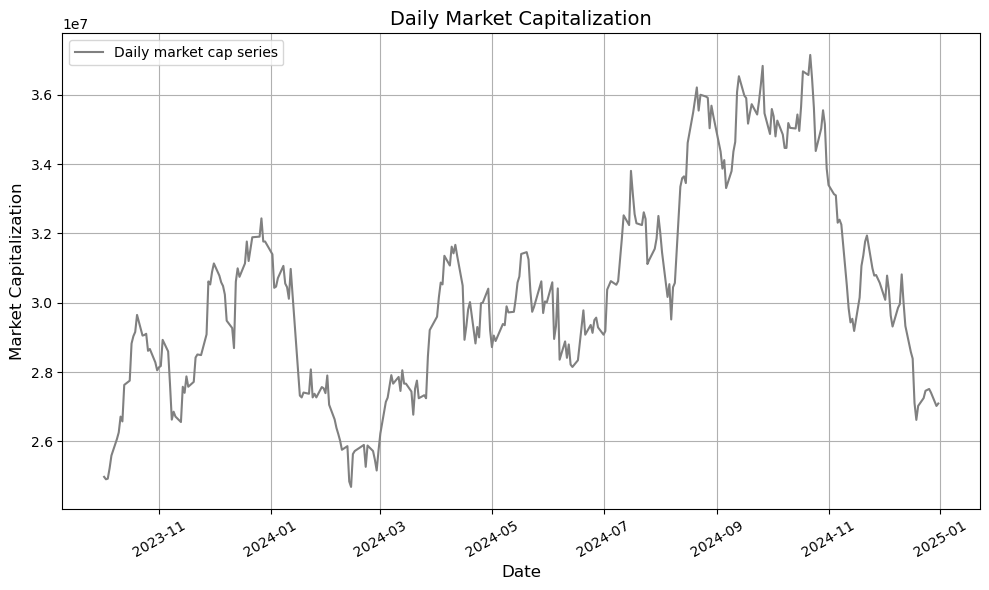

In [61]:
# Plotting the market capitalization data
plt.figure(figsize=(10, 6))

# Plot the 'Market_Cap' series
plt.plot(stock_cap_daily.index, stock_cap_daily['Market_Cap'], label='Daily market cap series', color='grey')

# Add labels and titles
plt.title("Daily Market Capitalization", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Market Capitalization", fontsize=12)
plt.grid(True)
plt.legend()
plt.xticks(rotation=30)
plt.tight_layout()

# Display the plot
plt.show()

### Estimate asset value and volatility